# Normalizing flows in simple words

Suppose we have a sample of objects $X = \{x_i\}_{i=1}^n$ that come from an unknown distribution $p_x(x)$ and we want our model to *learn this distribution*. What do I mean by learning a distribution? There are many ways to define such task, but data scientists mostly settle for 2 things:
1. learning to **score** the objects' probability, i.e. learning the probability density function $p_x(x)$, and/or
2. learning to sample from this unknown distribution, which implies the ability to **sample new, unseen objects**.

Does this description ring a bell? Yes, I'm talking precisely about generative models!

Generative modeling is a huge field of research. GANs, being one of the brightest examples, alow data scientists to [generate surprisingly realistinc pictures of people](https://thispersondoesnotexist.com/) and more. However, today I want to tell you about a different approach to this task, namely normalizing flows.

The idea behind normalizing flows is very simple. Let's get back to our sample $X$ from an unknown distribution $p_x(x)$. Let's additionaly pick some well-known distribution $p_z(z)$ as base (standard normal or uniform distribution will do). If we had two functions, one that transformed objects from base distribution into objects from target distribution and the other one that performs the reverse mapping, then we could consider our problem solved! Indeed, suppose we have and object $x$, which we'd like to score. Then if we had a function $f$, which maps objects $x \sim p_x(x)$ into objects $z \sim p_z(z)$, than scoring would be easy: we transform object $x$ into object $f(x)$ and compute its probability $p_z(f(x))$ et voila. And the other way around: suppose we want to sample from the unknown distribution $p_x(x)$. Let's sample from the well-known distribution $p_z(z)$ and then use our second function $g$, which will transform objects $z \sim p_z(z)$ into objects $x \sim p_x(x)$ and thus we have our sample.

However, where do we get such functions $f$ and $g$? Can we learn them from our data? It turns out, that (under certain constraints) we can indeed learn our function $f$ from data! What about $g$? Well, let's additionally constraint our function $f$ to be *invertible*. This way we get $g$ as an inverse mapping $f^{-1}$ for free!

The only question left is how can we find such mapping $f$? It turns out, that there is a change of variables formula, that allows us to parametrize our mapping as a neural network and learn it! Here is this formula:

$$
p_x(x_i) = p_z(f(x_i)) \left| \det \frac{\partial f(x_i)}{\partial x_i} \right|
$$

Given this formula, we can deduce formulas for likelihood and log likelihood of observing our sample:

$$
L(X) = \prod_{i=1}^n p_x(x_i) \Rightarrow \log L(X) = \sum_{i=1}^n \log p_x(x_i) = \sum_i \left( \log p_z(f(x_i)) + \log \left| \det \frac{\partial f(x_i)}{\partial x_i} \right| \right)
$$

This yields the negative log likelihood loss in a form of:

$$
\text{NLL} = - \frac1n \sum_{i=1}^n \left( \log p_z(f(x_i)) + \log \left| \det \frac{\partial f(x_i)}{\partial x_i} \right| \right)
$$

Which means we can program and minimize.

Let's try it on a simple example: suppose our unknown distribution is a multivariate normal distribution, which is shifted from the origin of coordinates and has a non-identity covariance matrix. More specifically, in this example:

$$
\mu = \begin{pmatrix} 5 \\ 7 \end{pmatrix},\ \Sigma = \begin{pmatrix} 2 & 7 \\ 7 & 1 \end{pmatrix}
$$

We will take a standard normal distribution (i.e. $\mu$ is zero and $\Sigma$ is identity matrix) and will try to learn a linear mapping $f$ from target to base distribution.

Let's generate a sample from our target distribution, say, 500 points shall suffice.

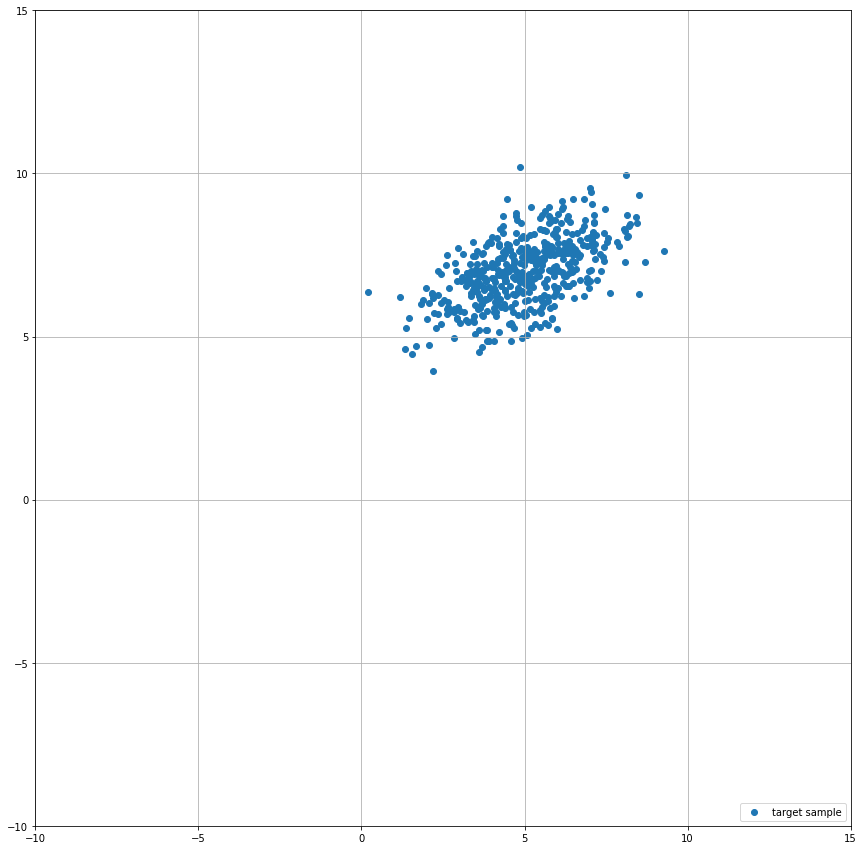

In [1]:
import matplotlib.pyplot as plt
import torch

from torch.distributions.multivariate_normal import MultivariateNormal


# Target distribution parameters.
target_mu = torch.tensor([5., 7.])
target_sigma = torch.tensor(
    [
        [2., .7], 
        [.7, 1.]
    ]
)

# Target distribution.
target_distribution = MultivariateNormal(target_mu, target_sigma)

# Sample 500 points from target distribution.
target_sample = target_distribution.sample([500])

# Plot target sample.
plt.figure(figsize=(15, 15))
plt.scatter(target_sample[:, 0], target_sample[:, 1], label='target sample')
plt.xlim(-10, 15)
plt.ylim(-10, 15)
plt.gca().set_aspect('equal', adjustable='box')
plt.legend(loc='lower right')
plt.grid()

Now let's define our normalizing flow. As I mentioned earlier, let's settle for a linear function, which in our case can be defined as

$$
f(x)^T = x^T W + b^T
$$

> Note: you might wonder, why did I write a formula for the transpose of a vector $f(x)$. This has to do with a fact that in PyTorch we mostly deal with batched inputs, which are matrices $X$ of size $B \times N$, where $B$ is the batch size and $N$ is the size of each single vector. This means that we get a matrix with **rows** corresponding to **transposed** elements. And in case of such input, our formula would look like following: $f(X) = XW + B$, which is the way I compute output in the following code.

Our `LinearFlow` model will have 2 main functions:
1. `forward`, which implements our mapping $z = f(x)$ from unknown distribution $p_z(z)$ to our base distribution and
2. `inverse`, which inverses our mapping $f$ into $x = f^{-1}(z)$.

Let's implement them! One last thing is that we want to use our forward-pass to train our model, which means that we will need to return $\log \left| \det \frac{\partial f(x_i)}{\partial x_i} \right|$ from it. In case of our linear mapping, $\frac{\partial f(x_i)}{\partial x_i} = W^T$, which means that $\log \left| \det \frac{\partial f(x_i)}{\partial x_i} \right| = \log \left| \det W^T \right| = \log \left| \det W \right|$. In order to efficiently compute such logarithm, I use the PyTorch's [`slogdet` function](https://pytorch.org/docs/stable/generated/torch.slogdet.html).

In [2]:
import torch.nn as nn


class LinearFlow(nn.Module):
    def __init__(self, size=2):
        super().__init__()
        # Initialize parameters to be an identity mapping.
        self.W = nn.Parameter(torch.eye(size))
        self.b = nn.Parameter(torch.zeros(1, size))
    
    def forward(self, target):
        # Forward: from target to base distribution
        base = target @ self.W + self.b
        return base, torch.slogdet(self.W).logabsdet
    
    def inverse(self, base):
        # Inverse: from base distribution to target
        target = (base - self.b) @ torch.inverse(self.W)
        return target

Now that we've defined our model, let's go ahead and use it to solve our task.

In [3]:
from PIL import Image


# Initialize the flow, optimizer and base distribution.
normalizing_flow = LinearFlow()
optim = torch.optim.Adam(normalizing_flow.parameters())
base_distribution = MultivariateNormal(torch.zeros(2), torch.eye(2))

# I will reuse this figure to record the training progress.
fig = plt.figure(figsize=(15, 15))
images = []
for i in range(9000):
    # On each iteration we use forward pass to transform target
    # sample to sample from base distribution.
    base_sample, logabsdet = normalizing_flow(target_sample)
    
    # Once we have the base sample, we compute our loss as sum
    # of log prob of our sample and log abs det of the gradient.
    loss = base_distribution.log_prob(base_sample) + logabsdet
    
    # Now we take a mean over the batch and negate it such that
    # we increase the probability.
    loss = -torch.mean(loss)
    
    # Backward pass.
    optim.zero_grad()
    loss.backward()
    optim.step()
    
    # Every 300 iterations we visualize the resulting transformation.
    if i % 300 == 0:
        # Sample from the base distribution.
        base_sample = base_distribution.sample([500])
        
        # Use inverse pass to obtain a sample from target distribution.
        with torch.no_grad():
            predicted_sample = normalizing_flow.inverse(base_sample)
        
        # Plot target and predicted samples.
        plt.scatter(target_sample[:, 0], target_sample[:, 1], label='target sample')
        plt.scatter(predicted_sample[:, 0], predicted_sample[:, 1], label='predicted sample')
        plt.xlim(-10, 15)
        plt.ylim(-10, 15)
        plt.gca().set_aspect('equal', adjustable='box')
        plt.grid()
        plt.legend(loc='lower right')
        
        # Save plot to image and clear figure.
        fig.canvas.draw()
        images.append(Image.frombytes('RGB', fig.canvas.get_width_height(), fig.canvas.tostring_rgb()))
        fig.clear()
        
plt.close()  # To disable empty figure output.

In [4]:
# Save images as a gif.
image, *images = images
image.save('normalizing-flows-training.gif', 'GIF', append_images=images, save_all=True, duration=200, loop=0)

This code produces the following `gif`:

![training progress](normalizing-flows-training.gif "training progress")

It works! Well, it works, given that we are using a very simple flow and it is solving a very simple task. However, it still amazes me that we can use sum of some log probability and a logdet of our matrix to learn a transformation from one gaussian to another. Well, here you go!

It goes without saying that normalizing flows are not limited to linear transformations on a plane. Researchers have come up with multiple different types of normalizing flows (and you can find many references and impementations in [this github repository](https://github.com/kamenbliznashki/normalizing_flows)). And the greatest part of it is that you can stack them just like you'd stack layers in a neural network! Given that each flow in a sequence provides you with a logdet and an `inverse` method, you can easily train it using a logprob from base distribution and a sum of logdets and inverse this sequence afterwards without any problem!

![stuck more flows](normalizing-flows.png)

*Image is taken from [this great blog post](https://lilianweng.github.io/lil-log/2018/10/13/flow-based-deep-generative-models.html) by Lilian Weng.*

However, this being said, normalizing flows are not a silver bullet. This is just an approach to solve generative modelling problem with its own pros and cons.

Let's start on the positive side. Strictly speaking, normalizing flows have only one advantage, but its a huge one. Namely, in normalizing flows you only train one model and you train it by directly maximizing the likelihood. This might seem like a strange point, but remember how I talked about GANs in the beginning of this article? They don't enjoy the same privilege! With GAN you have to train two models simultaneously. And keeping these models balanced is crucial if you want your generator to actually train. Anyone who tried to implement a GAN knows that training is a no joke because of this balance being very elusive. And, save for the GAN and VAE (which also train one model, but tend to yield highly blurred images because of its own problems), there is basically no real challenge in generative models as far as I know.

That was the advantage, what about disadvantages?

First of all, we want our model to additionally return the logarithm of determinant of its transformation gradient which is not great, because computing a determinant is in general an $O(n^3)$ task (however, for big $n$ there are [more sophisticated methods](https://en.wikipedia.org/wiki/Determinant#Calculation) that allow to drop the power as far as to 2.373). And we have to do this computation on every step of training. This isn't good! However, the computation is only slow in general case, we can easily compute a determinant of a triangular matrix as a product of its diagonal elements in a $O(n)$ which is nice. I already mentioned [github repository](https://github.com/kamenbliznashki/normalizing_flows) with many implementations and references of different normalizing flows. All (or at least most) of them are specifically tailored to create a gradient matrix of a specific structure, which allows the model to compute logdet in a brief.

Much deeper problem comes from the fact that we constrained our model to be invertible. And the problem is more complex than it might seem from the first glance. Indeed, linear layer is invertible, ReLU is not, but LeakyReLU is. What more do you want? The problem here lies on a different plane. Because we want all our transformations to be invertible, we inevitably need to **keep the data dimensions intact** every step of the way! And this is what bans normalizing flows from the world of high-dimensional data including high-resolution pictures, with which GANs are so successful! There have been some attempts, including [2018 FFJORD paper](https://arxiv.org/abs/1810.01367), which seek to mitigate this problem by predicting the way you transform data instead of the output of your transformation, but as far as I understand it, high-res pictures field is still mostly dominated by GANs. However, when it comes to generative models on a smaller scaled objects, normalizing flows is a legit technique, which you might want to consider using, as it will probably save you lots of time on training compared to a GANs.

This is all. Thank you for your time and I hope that this was interesting and helpful.